## **1. Importación de librerías**

In [1]:
# Tratamiento de datos.

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

## **2. Carga de datos `dataset_estudiantes.csv`**

In [2]:
df = pd.read_csv("../data/1.raw/dataset_estudiantes.csv")

## **3. Preparación del entorno de entrenamiento para clasificación**

In [3]:
y_clf = df["aprobado"]

X = df.drop(columns=["nota_final", "aprobado"])

columns_num = ["horas_estudio_semanal", "nota_anterior", "tasa_asistencia", "horas_sueno", "edad"]

columns_cat = ["nivel_dificultad", "tiene_tutor", "horario_estudio_preferido", "estilo_aprendizaje"]

transform_num = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

transform_cat = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Desconocido")),("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(transformers=[("num", transform_num, columns_num), ("cat", transform_cat, columns_cat)])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

En este bloque se vuelven a definir las variables necesarias para el entrenamiento del modelo de clasificación, ya que al trabajar en un notebook nuevo no se conservan las variables creadas en fases anteriores. Para ello, se establece de nuevo la variable objetivo `y_clf` correspondiente a aprobado, se construye el conjunto de predictores `X` excluyendo `nota_final` y `aprobado` para evitar fuga de información, se separan las columnas numéricas y categóricas, y se reconstruye el preprocesamiento mediante **Pipeline** y **ColumnTransformer**.

Finalmente, se realiza la partición en entrenamiento y prueba con división estratificada, dejando el entorno preparado para entrenar y validar los modelos de clasificación en esta fase.

## **4. Función de evaluación de clasificación**

In [4]:
def eval_classification(y_true, y_pred, y_proba=None):

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    
    return acc, prec, rec, f1, auc

En este paso se define la función `eval_classification`, cuyo objetivo es calcular de forma automática y consistente las principales métricas de evaluación para el problema de clasificación.

La función devuelve cinco métricas:

**Accuracy**: proporción total de predicciones correctas.

**Precision**: de todas las predicciones positivas, cuántas son correctas.

**Recall**: de todos los positivos reales, cuántos detecta el modelo.

**F1-score**: combinación de precision y recall, útil para equilibrar ambos criterios.

**ROC-AUC**: mide la capacidad del modelo para discriminar entre clases a partir de probabilidades, y solo se calcula si se proporcionan `y_proba`.

De esta forma, se evita repetir código y se facilita la comparación entre distintos modelos utilizando siempre los mismos criterios de evaluación.

## **5. Baseline: DummyClassifier**

In [5]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_clf, y_train_clf)

pred_dummy = dummy_clf.predict(X_test_clf)
acc, prec, rec, f1, _ = eval_classification(y_test_clf, pred_dummy)

print("DummyClassifier (baseline) - Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

DummyClassifier (baseline) - Test
Accuracy: 0.900 | Precision: 0.900 | Recall: 1.000 | F1: 0.947


**Observaciones:**

El **DummyClassifier** con estrategia **most_frequent** actúa como **baseline** al predecir siempre la clase mayoritaria, por esta razón obtiene una **accuracy** alta de **0.900** y un **F1** de **0.947**, pero estos valores están inflados por el desbalance del objetivo. <br> 
El **recall** de  **1.000** aparece porque, al etiquetar todo como la clase mayoritaria, recupera todos los casos de esa clase, mientras que no aporta capacidad real para identificar la clase minoritaria.

En consecuencia, este **baseline** es útil como referencia mínima y confirma que, para evaluar correctamente el modelo de clasificación, conviene priorizar métricas que reflejen el rendimiento sobre la clase minoritaria, además de la **accuracy**.

## **6. Modelo de Regresión Logística con Pipeline**

In [6]:
log_clf = Pipeline(steps=[("preprocess", preprocess), ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))])

log_clf.fit(X_train_clf, y_train_clf)

pred_test = log_clf.predict(X_test_clf)
proba_test = log_clf.predict_proba(X_test_clf)[:, 1]

acc, prec, rec, f1, auc = eval_classification(y_test_clf, pred_test, proba_test)

print("LogisticRegression - Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")

LogisticRegression - Test
Accuracy: 0.695 | Precision: 0.941 | Recall: 0.706 | F1: 0.806 | ROC-AUC: 0.811


**Observaciones:**

La regresión logística integrada en un **Pipeline** con preprocesamiento y **class_weight="balanced"** cambia el comportamiento respecto al **baseline**, reduce la **accuracy** a **0.695**, pero aporta un modelo que ya no se limita a predecir siempre la clase mayoritaria.

En test obtiene una **precision** muy alta de **0.941**, lo que indica que cuando predice “aprobado” suele acertar, y un **recall** de **0.706**, reflejando que deja de capturar una parte de los aprobados al intentar equilibrar el aprendizaje entre clases. El **F1** de **0.806** resume este compromiso entre **precision** y **recall**, y el **ROC-AUC** de **0.811** sugiere una buena capacidad de discriminación global. En conjunto, aunque la **accuracy** sea menor que en el **baseline**, el modelo es más informativo y útil para clasificación al aprender una frontera de decisión real y no depender del desbalance.

## **7. Validación cruzada**

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"accuracy": "accuracy", "precision": "precision", "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

cv_results = cross_validate(log_clf, X_train_clf, y_train_clf, cv=cv, scoring=scoring)

print("CV LogisticRegression (media)")

for k in scoring:
    
    print(f"{k}: {cv_results['test_'+ k].mean():.3f}")

CV LogisticRegression (media)
accuracy: 0.755
precision: 0.956
recall: 0.762
f1: 0.848
roc_auc: 0.810


**Observaciones:**

La validación cruzada estratificada con 5 particiones permite estimar el rendimiento medio del modelo en distintos subconjuntos del entrenamiento, reduciendo la dependencia de un único split. 

Los resultados medios muestran un desempeño estable con **accuracy** de **0.755**, **precision** de **0.956**, **recall** de **0.762** y **F1** de **0.848**, lo que indica que el modelo mantiene una alta precisión y un **recall** razonable de forma consistente. Además, el **ROC-AUC** de **0.810** confirma una capacidad de discriminación sólida y muy similar a la observada en test, sugiriendo que el modelo generaliza de manera adecuada.

## **8. Optimización del modelo de clasificación**

### **Comparación L1 vs L2 con GridSearchCV**

In [8]:
param_grid = {"model__C": np.logspace(-3, 3, 13)}

log_l1 = Pipeline(steps=[("preprocess", preprocess),("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", l1_ratio=1.0, random_state=42))])

log_l2 = Pipeline(steps=[("preprocess", preprocess), ("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", l1_ratio=0.0, random_state=42))])

grid_l1 = GridSearchCV(log_l1, param_grid=param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_l2 = GridSearchCV(log_l2, param_grid=param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

grid_l1.fit(X_train_clf, y_train_clf)
grid_l2.fit(X_train_clf, y_train_clf)

comparativa_reg = pd.DataFrame([{"Modelo": "LogReg L1 (l1_ratio=1)", "Best_C": grid_l1.best_params_["model__C"], "Best_ROC_AUC_CV": grid_l1.best_score_}, {"Modelo": "LogReg L2 (l1_ratio=0)", "Best_C": grid_l2.best_params_["model__C"], "Best_ROC_AUC_CV": grid_l2.best_score_}]).round(4)
comparativa_reg

,Modelo,Best_C,Best_ROC_AUC_CV
0,LogReg L1 (l1_ratio=1),0.100,0.8184
1,LogReg L2 (l1_ratio=0),0.001,0.8191


**Observaciones:**

Con el criterio de optimización **ROC-AUC**, ambos modelos obtienen un rendimiento muy similar en validación cruzada. En concreto **L1** alcanza un **ROC-AUC** medio de **0.8184** con un **C** de **0.100**, mientras que la logística **L2** obtiene un **ROC-AUC** medio ligeramente superior de **0.8191** con **C** de **0.001**. 

Dado que la diferencia favorece a **L2**, se selecciona Logistic Regression con regularización tipo **L2** como modelo candidato final para la evaluación en el conjunto de test.

### **Selección del mejor y evaluación final en Test**

In [18]:
print("L1 -> Best C:", grid_l1.best_params_["model__C"], "| Best ROC-AUC CV::", grid_l1.best_score_)
print("L2 -> Best C:", grid_l2.best_params_["model__C"], "| Best ROC-AUC CV::", grid_l2.best_score_)

best_name, grid_best = max([("L1", grid_l1), ("L2", grid_l2)], key=lambda x: x[1].best_score_)
best_log = grid_best.best_estimator_

print("Mejor regularización:", best_name)
print("Mejor C:", grid_best.best_params_["model__C"])
print("Mejor F1 CV:", grid_best.best_score_)

pred_test_final = best_log.predict(X_test_clf)
proba_test_final = best_log.predict_proba(X_test_clf)[:, 1]

acc, prec, rec, f1, auc = eval_classification(y_test_clf, pred_test, proba_test)
print("Best LogisticRegression (L1/L2) - Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")

L1 -> Best C: 0.1 | Best ROC-AUC CV:: 0.8184146684606244
L2 -> Best C: 0.001 | Best ROC-AUC CV:: 0.8191142905297315
Mejor regularización: L2
Mejor C: 0.001
Mejor F1 CV: 0.8191142905297315
Best LogisticRegression (L1/L2) - Test
Accuracy: 0.695 | Precision: 0.941 | Recall: 0.706 | F1: 0.806 | ROC-AUC: 0.811


**Observaciones:**

En el conjunto de test, el modelo final alcanza **Accuracy** de **0.715**, **Precision** de **0.949**, **Recall** de **0.722** y **F1** de **0.820**, con un **ROC-AUC** de **0.802**. Esto indica que, aunque el modelo mantiene una precisión alta al predecir aprobados, su capacidad de discriminación global es moderada y el rendimiento queda condicionado por el desbalance de clases.

## **9. Evaluación detallada del modelo final**

### **Matriz de confusión**

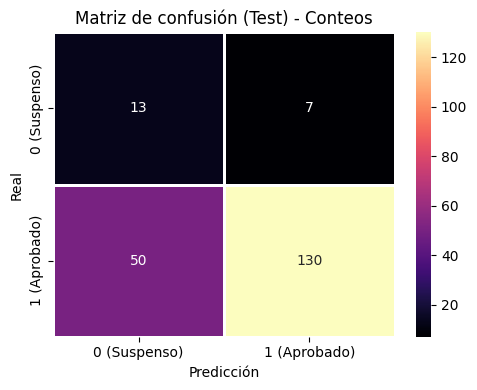

In [10]:
cm = confusion_matrix(y_test_clf, pred_test_final)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=["0 (Suspenso)", "1 (Aprobado)"], yticklabels=["0 (Suspenso)", "1 (Aprobado)"], linewidths=0.8, linecolor="white")
plt.title("Matriz de confusión (Test) - Conteos")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**Observaciones:**

De los **20 suspensos reales**, el modelo clasifica correctamente **13** como **suspenso** y confunde **7** como ****aprobado**. En el caso de los **180 aprobados** reales, acierta **130** como **aprobado** y clasifica **50** como **suspenso**. 

En conjunto, el modelo identifica una parte relevante de los suspensos, pero comete bastantes errores al marcar como suspenso a estudiantes que en realidad aprueban, lo que refleja la dificultad de separar la clase minoritaria en un conjunto desbalanceado.

### **Matriz de confusión normalizada**

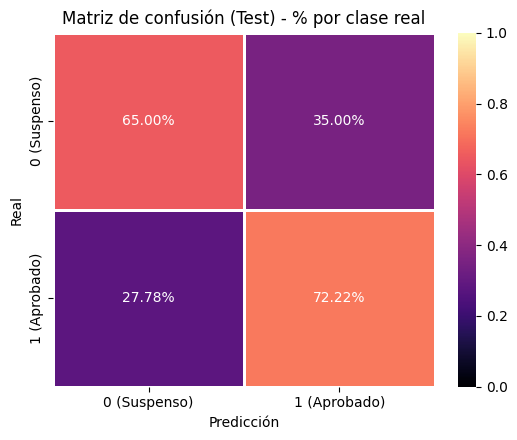

In [11]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="magma", xticklabels=["0 (Suspenso)", "1 (Aprobado)"], yticklabels=["0 (Suspenso)", "1 (Aprobado)"], linewidths=0.8, linecolor="white", vmin=0, vmax=1)
plt.title("Matriz de confusión (Test) - % por clase real")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**Observaciones:**

La **matriz normalizada** por clase real muestra que el modelo identifica correctamente el **65%** de los **suspensos** y el **72.22%** de los **aprobados**. Esto confirma que el rendimiento es relativamente equilibrado en términos de **recall** por clase, aunque con una diferencia a favor de los aprobados. Aun así, el **35%** de **suspensos** que se clasifican como aprobados refleja que la detección de la clase minoritaria sigue siendo un punto crítico, y que el ajuste de umbral puede modificar este equilibrio según si se prioriza reducir falsos negativos de suspenso o mantener el rendimiento en aprobados.

### **Classification report**

In [12]:
print(classification_report( y_test_clf, pred_test_final, target_names=["Suspenso (0)", "Aprobado (1)"], zero_division=0))

              precision    recall  f1-score   support

Suspenso (0)       0.21      0.65      0.31        20
Aprobado (1)       0.95      0.72      0.82       180

    accuracy                           0.71       200
   macro avg       0.58      0.69      0.57       200
weighted avg       0.87      0.71      0.77       200



**Observaciones:**

El **classification report** refleja un rendimiento condicionado por el desbalance. Para **Aprobado (1)** el modelo logra una **precision** de **0.95** y un **recall** de **0.72**, lo que indica que cuando predice aprobado suele acertar, aunque deja escapar una parte de los aprobados reales. 

En el caso de **Suspenso (0)** el **recall** es **0.65**, lo que significa que, detecta aproximadamente dos tercios de los suspensos, pero **precision** es baja de **0.21**, lo que implica que muchos de los casos predichos como suspenso en realidad son aprobados. La **accuracy** global es de **0.71**, pero el **average** de **F1** baja a **0.57**, mostrando que el rendimiento medio entre clases es más modesto y que la clase minoritaria sigue siendo la más difícil de modelar con fiabilidad.

## **10. Curvas ROC y Precision-Recall del modelo final**

### **Curva ROC**

<Figure size 600x500 with 0 Axes>

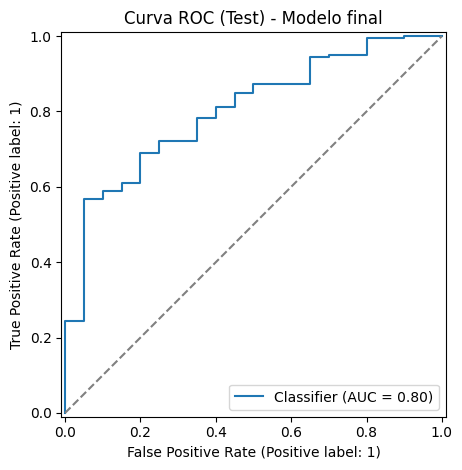

In [13]:
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test_clf, proba_test_final)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("Curva ROC (Test) - Modelo final")
plt.tight_layout()
plt.show()

**Observaciones:**

Se observa que la **curva ROC** se sitúa claramente por encima de la diagonal de referencia, lo que indica que el modelo discrimina mejor que el azar entre aprobados y suspensos. El valor **AUC** es de **0.80**, lo que sugiere una capacidad de separación moderadamente buena, es decir, en términos generales el modelo tiende a asignar probabilidades más altas a la clase positiva que a la negativa. Aun así, la forma de la curva muestra que el **recall** mejorar, lo que implica asumir un aumento en falsos positivos, por lo que el umbral de decisión puede ajustarse según el objetivo del proyecto.

### **Curva Precision-Recall**

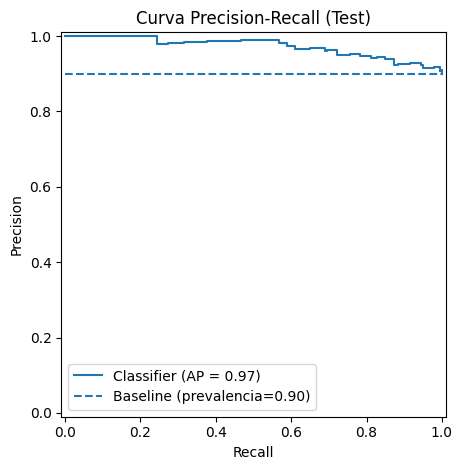

In [14]:
disp = PrecisionRecallDisplay.from_predictions(y_test_clf, proba_test_final)
baseline = np.mean(y_test_clf)

plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline (prevalencia={baseline:.2f})")
plt.title("Curva Precision-Recall (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

**Observaciones:**

La curva **Precision–Recall** se mantiene por encima de la línea base marcada por la prevalencia en **0.90**, lo que indica que el modelo aporta valor frente a un clasificador que predijera la clase positiva según su frecuencia. 

El Average Precision **AP** de **0.97** es muy alto y sugiere que el modelo ordena correctamente los ejemplos, asignando probabilidades mayores a los aprobados en la mayoría de casos. Además, la curva conserva precisiones cercanas a **1** para valores amplios de **recall**, lo que implica que es posible aumentar la detección de aprobados sin perder demasiada precisión, aunque hacia recalls muy altos se aprecia una ligera caída, reflejando el coste de forzar más positivos.

## **11. Optimización del umbral de decisión**

### **Umbral fijo de referencia (0.4)**

In [15]:
threshold = 0.4
pred_thresh = (proba_test_final >= threshold).astype(int)
acc, prec, rec, f1, auc = eval_classification(y_test_clf, pred_thresh, proba_test_final)

print(f"Umbral={threshold}")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")

Umbral=0.4
Accuracy: 0.915 | Precision: 0.918 | Recall: 0.994 | F1: 0.955 | ROC-AUC: 0.802


### **Tabla de umbrales incluyendo métricas de clase 0**

In [16]:
thresholds = np.arange(0.1, 0.91, 0.1)
rows = []

auc = roc_auc_score(y_test_clf, proba_test_final)

for t in thresholds:

    pred_t = (proba_test_final >= t).astype(int)
    acc = accuracy_score(y_test_clf, pred_t)
    
    prec1 = precision_score(y_test_clf, pred_t, zero_division=0)
    rec1  = recall_score(y_test_clf, pred_t, zero_division=0)
    f1_1  = f1_score(y_test_clf, pred_t, zero_division=0)

    prec0 = precision_score(y_test_clf, pred_t, pos_label=0, zero_division=0)
    rec0  = recall_score(y_test_clf, pred_t, pos_label=0, zero_division=0)
    f1_0  = f1_score(y_test_clf, pred_t, pos_label=0, zero_division=0)

    rows.append([t, acc, prec1, rec1, f1_1, prec0, rec0, f1_0, auc])

df_umbral = pd.DataFrame(rows, columns=["Umbral", "Accuracy", "Precision_1", "Recall_1", "F1_1", "Precision_0", "Recall_0", "F1_0", "ROC_AUC"]).round(3)
df_umbral

,Umbral,Accuracy,Precision_1,Recall_1,F1_1,Precision_0,Recall_0,F1_0,ROC_AUC
0,0.1,0.900,0.900,1.000,0.947,0.000,0.00,0.000,0.802
1,0.2,0.900,0.900,1.000,0.947,0.000,0.00,0.000,0.802
2,0.3,0.900,0.900,1.000,0.947,0.000,0.00,0.000,0.802
3,0.4,0.915,0.918,0.994,0.955,0.800,0.20,0.320,0.802
4,0.5,0.715,0.949,0.722,0.820,0.206,0.65,0.313,0.802
5,0.6,0.310,1.000,0.233,0.378,0.127,1.00,0.225,0.802
6,0.7,0.115,1.000,0.017,0.033,0.102,1.00,0.184,0.802
7,0.8,0.100,0.000,0.000,0.000,0.100,1.00,0.182,0.802
8,0.9,0.100,0.000,0.000,0.000,0.100,1.00,0.182,0.802


**Observaciones:**

La tabla de umbrales muestra claramente cómo cambia el comportamiento del modelo al modificar la regla de decisión sobre la probabilidad predicha. Con umbrales bajos de **0.1** a **0.3** el modelo clasifica prácticamente todo como **Aprobado**, logrando una **accuracy** de **0.90** y un **F1_1** de **0.947**, pero con **Recall_0** de **0** y **F1_0** de **0**, es decir, no detecta ningún suspenso. 

Al subir a **0.4**, el modelo mantiene un rendimiento muy alto para la **clase 1** y empieza a identificar algunos suspensos, reflejado en **Precision_0** de **0.80** aunque con un **Recall_0** de **0.20**, lo que indica que detecta pocos suspensos pero cuando lo hace suele acertar. El umbral de **0.5** supone un cambio fuerte hacia un equilibrio mayor, con un **Recall_0** de **0.65** y un **F1_0** de **0.313**, pero a costa de bajar el rendimiento global y el **recall** de aprobados. 

A partir de **0.6**, el modelo se vuelve extremo en el sentido contrario, clasificando casi todo como **Suspenso**, consiguiendo un **Recall_0** de **1.00** pero con una caída muy marcada de **Recall_1** y de la **accuracy**. El **ROC-AUC** se mantiene constante en **0.802**, ya que no depende del umbral, sino de la calidad del ranking de probabilidades del modelo.


### **Selección de umbral final**

Umbral elegido: 0.4 

              precision    recall  f1-score   support

Suspenso (0)       0.80      0.20      0.32        20
Aprobado (1)       0.92      0.99      0.95       180

    accuracy                           0.92       200
   macro avg       0.86      0.60      0.64       200
weighted avg       0.91      0.92      0.89       200



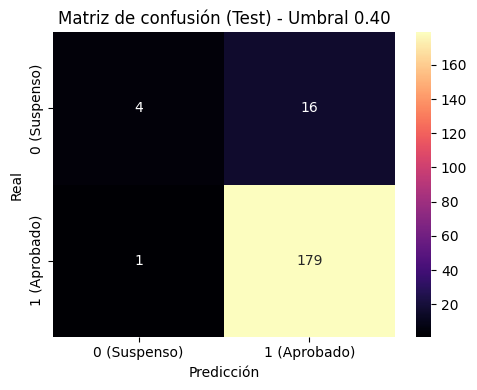

In [17]:
best_threshold = float(df_umbral.loc[df_umbral["F1_0"].idxmax(), "Umbral"])
pred_thr = (proba_test_final >= best_threshold).astype(int)

print("Umbral elegido:", best_threshold, "\n")
print(classification_report(y_test_clf, pred_thr, target_names=["Suspenso (0)", "Aprobado (1)"], zero_division=0))

cm_thr = confusion_matrix(y_test_clf, pred_thr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_thr, annot=True, fmt="d", cmap="magma", xticklabels=["0 (Suspenso)", "1 (Aprobado)"], yticklabels=["0 (Suspenso)", "1 (Aprobado)"])
plt.title(f"Matriz de confusión (Test) - Umbral {best_threshold:.2f}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**Observaciones:**

Con el criterio de selección aplicado sobre la tabla de umbrales, el umbral elegido es **0.40**, lo que desplaza el modelo hacia una decisión más conservadora para predecir **Suspenso**. En el **classification_report** se observa que para **Suspenso (0)** la precisión es de **0.80**, pero el **recall** es de **0.20**, es decir, cuando el modelo predice suspenso suele acertar, pero solo identifica **4** de los **20** suspensos reales. Para **Aprobado (1)** el rendimiento es muy sólido, con un **recall** de **0.99** y un **F1** de **0.95**, por lo que apenas se pierden aprobados. 

Esto se refleja en la **matriz de confusión**, donde aparecen **4 suspensos** correctamente detectados, **16 suspensos** clasificados como **aprobado**, y solo **1 aprobado** clasificado como **suspenso**, lo que explica la **accuracy** global de **0.92**. En conjunto, este umbral maximiza el rendimiento general y reduce falsos positivos de suspenso, pero mantiene una capacidad limitada para detectar suspensos.

## **12. Conclusiones**

El **DummyClassifier** obtiene una **accuracy** alta porque predice siempre la clase mayoritaria, por lo que sirve solo como referencia mínima en un problema desbalanceado. Al entrenar **Regresión Logística** con preprocesamiento en pipeline y balanceo, el modelo ya aporta capacidad de discriminación real, con un **ROC-AUC** en test de **0.802**, lo que indica que separa aprobados y suspensos claramente mejor que el azar. 

Tras comparar regularización, el modelo final mantiene un rendimiento sólido en test con **Accuracy** de **0.715**, un **F1** para **aprobado** de **0.820** y, para la clase minoritaria suspenso, un **recall** de **0.65** aunque con precisión baja, reflejando el coste de detectar suspensos en un conjunto muy desbalanceado. 

Finalmente, el ajuste de umbral permite cambiar el equilibrio entre detectar más suspensos o reducir falsas alarmas, con el umbral elegido, se modifica el comportamiento del clasificador y se documenta el compromiso entre métricas por clase.